# Planning and Learning with Tabular Methods

In [1]:
""" Imports """

import math
import numpy as np
import random as rnd
import matplotlib.pyplot as plt

plt.style.use("seaborn")


""" Visualization tools """

def canvas_plot(ax=None) -> None:
    """ Border around gridworld using globals: SIZE X & Y """
    ax.hlines(-.5,       -.5, SIZE_X-.5, colors="k")
    ax.hlines(SIZE_Y-.5, -.5, SIZE_X-.5, colors="k")
    ax.vlines(-.5,       -.5, SIZE_Y-.5, colors="k")
    ax.vlines(SIZE_X-.5, -.5, SIZE_Y-.5, colors="k")
    
    
def draw_world(title="", annotated=True, show=False, ax=None):
    """ Needlessly fancy Gridworld plotter with outlines and annotations """
    if ax==None: fig, ax = plt.subplots()
        
    ax.imshow(WORLD)
    ax.set_axis_off()
    ax.text(.1, 1.05, title, transform=ax.transAxes, fontdict={"size":18})
    
    canvas_plot(ax)
    if annotated: # OOP scriptable object here!
        # Render Start "S"
        ax.text(*reversed(np.where(WORLD==2)), "S", 
                 fontdict={"size": 24}, c="w")
        # Render Finish "F"
        ax.text(*reversed(np.where(WORLD==3)), "F", 
                 fontdict={"size": 24}, c="w") 
        # Render Walls "#"
        for x, y in list(zip(*reversed(np.where(WORLD==0)))):
            ax.text(x-.3, y+.4, "#", fontdict={"size": 48}, c="k")
    
    if show: plt.show()
        
        
def path_taken(path:list, title="", ax=None) -> None:
    """ Shows the path taken during an episode or training """
    draw_world(title, annotated=True, show=False, ax=ax)
    ax.plot(*reversed(list(zip(*path))), lw=16)
    
    
ARROWS = {
    # RIGHT
    0: [[(0,0),(0,.4)],
        [(.1,0),(.2,.4)],
        [(-.1,0),(.2,.4)]],
    # DOWN
    1: [[(0,.4),(0,0)],
        [(.4,.2),(0,.1)],
        [(.4,.2),(0,-.1)]],
    # LEFT
    2: [[(0,0),(0,-.4)],
        [(.1,0),(-.2,-.4)],
        [(-.1,0),(-.2,-.4)]],
    # UP
    3: [[(0,-.4),(0,0)],
        [(-.4,-.2),(0,.1)],
        [(-.4,-.2),(0,-.1)]],
}    
offset = lambda point, val: (point[0]+val, point[1]+val)    
def draw_arrow(direction:int, position:tuple, color="r", ax=None) -> None:
    """ Arrow representing states'(position) greedy action(direction) """
    x = list(map(lambda arrow: offset(arrow, position[0]), list(zip(*ARROWS[direction]))[0]))
    y = list(map(lambda arrow: offset(arrow, position[1]), list(zip(*ARROWS[direction]))[1]))
    [ax.plot(*line, c=color) for line in list(zip(y, x))]
    
    
def visual_policy(Q:np.ndarray, title="", mask_lst=[], ax=None) -> None:
    """ Plots gridworld with arrows indicating states' greedy action """
    if ax==None: fig, ax = plt.subplots()
        
    draw_world(title, annotated=False, show=False, ax=ax)
    for (y,x), val in np.ndenumerate(np.argmax(Q, -1)):
        if WORLD[y,x] in mask_lst: draw_arrow(val, (y,x), ax=ax)    
    plt.show()

# Impassable walls

#### This gridworld is perfect for random walks around the walls

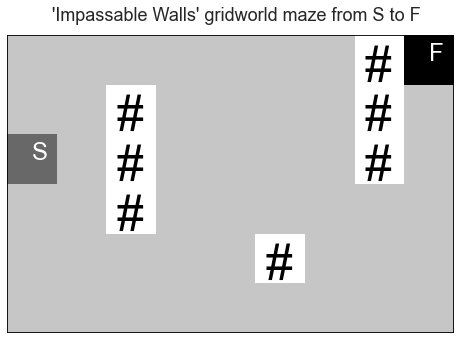

In [2]:
""" Toy Environment 'physics' """

WORLD = np.array([
    [1,1,1,1,1,1,1,0,3],
    [1,1,0,1,1,1,1,0,1],
    [2,1,0,1,1,1,1,0,1],
    [1,1,0,1,1,1,1,1,1],
    [1,1,1,1,1,0,1,1,1],
    [1,1,1,1,1,1,1,1,1],
])

SIZE_Y, SIZE_X = WORLD.shape
 
ACTION_SPACE = {
    0: (0,1),  # Right
    1: (1,0),  # Down
    2: (0,-1), # Left
    3: (-1,0)  # Up
}

direction = lambda p, a: (p[0]+a[0], p[1]+a[1])
is_legal = lambda s: (s[0]>=0 and s[0]<SIZE_Y) and (s[1]>=0 and s[1]<SIZE_X)

# Extra 'law' bool this time to make sure agent doesn't go through walls
is_wall = lambda s: WORLD[s] == 0
    
draw_world("'Impassable Walls' gridworld maze from S to F ")

# Random-sample one-step tabular Q-planning

### This is similar to an agent being present in the gridworld but transitions are executed at random instead

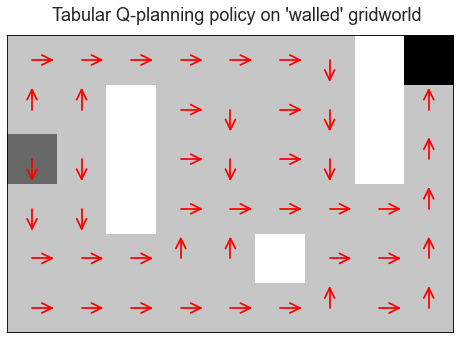

In [9]:
quality = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))

non_terminal_states = list(zip(*np.where((WORLD==1)|(WORLD==2))))

ALPHA = 2e-3
GAMMA = 0.99
for step in range(int(1e5)):
    state = rnd.choice(non_terminal_states)
    action = rnd.choice(list(ACTION_SPACE))
    
    move = direction(state, ACTION_SPACE[action])
    next_s = move if is_legal(move) and not is_wall(move) else state
    reward = 1 if next_s == np.where(WORLD==3) else 0
    
    quality[state][action] += ALPHA * (reward + GAMMA * np.max(quality[next_s]) - quality[state][action])

visual_policy(quality, "Tabular Q-planning policy on 'walled' gridworld", mask_lst=[1,2])

# Tabular Dyna-Q

In [47]:
""" Agent policy and value function """

def eps_greedy(Q:np.ndarray, state:tuple, eps=.66) -> int:
    """ Max action from state-action map with 1-eps chance"""
    if 1-eps < rnd.random(): 
        return rnd.choice(list(ACTION_SPACE))
    return np.argmax(Q[state])


def q_learning(Q:np.ndarray, s, a, r, s_) -> float:
    """ Off-policy value function maps transition from state to state
        Learns reward received plus discounted max next action value"""
    return Q[s][a] + ALPHA * (r + (GAMMA * np.max(Q[s_])) - Q[s][a])

### The agent will do a 66% random walk (blue) until it finds the terminal state (F)

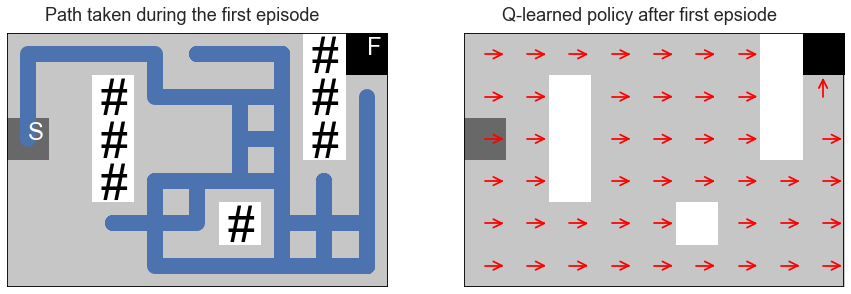

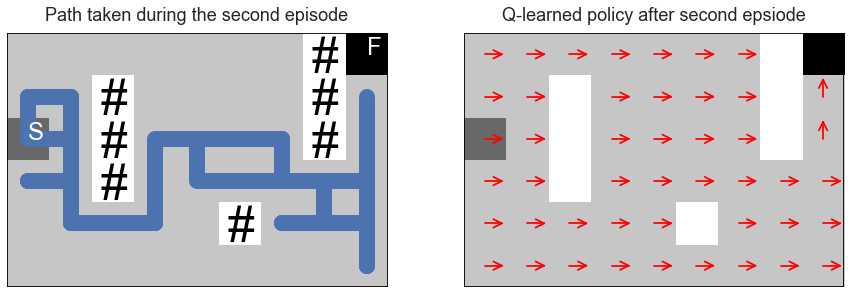

In [22]:
""" Q-learning only yields single updates at start of training"""

quality = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE)))

for episode in ["first", "second"]:
    path = []
    state = tuple(map(int, np.where(WORLD==2)))
    while state != np.where(WORLD==3):
        path.append(state)
        
        action = eps_greedy(quality, state)
        move = direction(state, ACTION_SPACE[action])
        next_s = move if is_legal(move) and not is_wall(move) else state
        reward = 1 if next_s == np.where(WORLD==3) else 0

        quality[state][action] = q_learning(quality, state, action, reward, next_s)
        state = next_s

    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    path_taken(path, f"Path taken during the {episode} episode", ax=ax[0])
    visual_policy(quality, f"Q-learned policy after {episode} episode", mask_lst=[1,2], ax=ax[1])

#### Above shows Q(0)learning yields only 1 update propagating backwards from the terminal state per episode
#### The expectation model introduced below has an optimal path after just 2 episode of DynaQ-learning

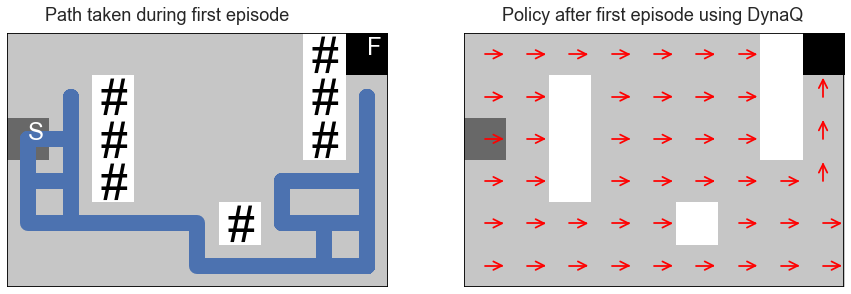

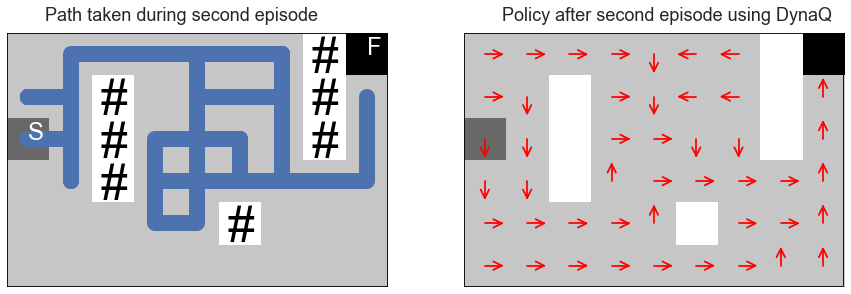

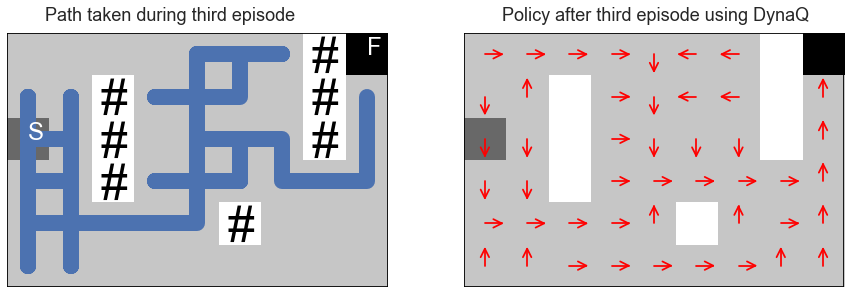

In [46]:
""" Three episodes with DynaQ-planning already yield a decent policy"""

quality = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE))).astype(float)
model = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE), 2)).astype("O")

planning_steps = SIZE_Y + SIZE_X

for episode in ["first", "second", "third"]:
    path = []
    state = tuple(map(int, np.where(WORLD==2)))
    while state != np.where(WORLD==3):
        path.append(state)
        
        # Standard RL-agent environment step
        action = eps_greedy(quality, state)
        move = direction(state, ACTION_SPACE[action])
        next_s = move if is_legal(move) and not is_wall(move) else state
        reward = 1 if next_s == np.where(WORLD==3) else 0
        
        # Q-learning update on current state-action
        quality[state][action] = q_learning(quality, state, action, reward, next_s)
        # Model is updated to expect successor state's reward received
        model[state][action] = next_s, reward

        # List all state-action transitions recorded in model
        visited_state_actions = list(zip(*np.where(model != 0.0)))
        for _ in range(planning_steps):
            # Pick a random transition 
            state = rnd.choice(visited_state_actions)[:-2]
            action = rnd.choice(list(filter(
                lambda m: m[:-2]==state, visited_state_actions)))[-2]
            # Get modelled reward and successor state 
            model_s, model_r = model[state][action]
            # Q-learning update with the modelled values
            quality[state][action] = q_learning(quality, state, action, model_r, model_s)

        state = next_s
        
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    path_taken(path, f"Path taken during {episode} episode" , ax=ax[0])
    visual_policy(quality, f"Policy after {episode} episode using DynaQ", mask_lst=[1,2], ax=ax[1])

#### Insightful here is the policy updates after the second episode that combine and connect the 2 random walks the agent had done

# Prioritised sweeping for a deterministic environment

### The DynaQ algorithm made quick work of navigating the maze but when scaled up to large grid worlds, this can spread out the focus of revision or waste valuable planning steps on less critical areas



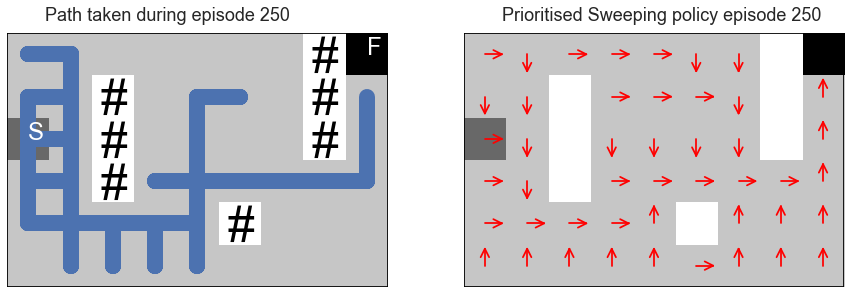

Training took 13 seconds.


In [42]:
import time; start = time.time()

def calc_priority(Q:np.ndarray, s, a, r, s_):
    """ Transition priority for PQueue """
    return np.abs(r + GAMMA * max(Q[s_][a_] for a_ in list(ACTION_SPACE)) - Q[s][a])

    # Similar to Q-learning update: curr_sa + ALPHA * (r + (GAMMA * max_a) - curr_sa)

# brain and memory
quality = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE))).astype(float)
model = np.zeros((SIZE_Y, SIZE_X, len(ACTION_SPACE), 2)).astype("O")

planning_steps = SIZE_Y + SIZE_X
theta = 1e-4 # Min priority value

for episode in range(1, 251):
    path = [] # For visuals
    
    # Reset origin and queue, each episode
    origin, queue = {}, []
    
    state = tuple(map(int, np.where(WORLD==2)))
    origin[state] = set() # Fix key error
    while state != np.where(WORLD==3):
        path.append(state)
        
        # Standard RL-agent environment step
        action = eps_greedy(quality, state)
        move = direction(state, ACTION_SPACE[action])
        next_s = move if is_legal(move) and not is_wall(move) else state
        reward = 1 if next_s == np.where(WORLD==3) else 0
        
        # Model is updated to expect successor state and reward received
        model[state][action] = next_s, reward
        # Entry added to 'origin dict' to keep track of how we got to the state
        if next_s not in origin: origin[next_s] = {(state, action)}
        else: origin[next_s].add((state, action))

        # Record important transition in a planning stack, sorted by priority
        priority = calc_priority(quality, state, action, reward, next_s)
        if priority > theta: # !!! I should insert not append and sort
            queue.append((state, action, priority))
            queue = sorted(queue, key=lambda k: k[-1], reverse=True)

        # Do n-planned recaps from the stack
        for n in range(planning_steps):
            # Finite planning steps loop
            # Breaks when stack is empty
            if len(queue)==0: break
                
            # Get state-action pair from top of stack
            # Get the modelled successor state and reward
            queue_s, queue_a = queue[0][:-1]
            model_s, model_r = model[queue_s][queue_a]
            queue.pop(0) # Pop the top of stack

            # Update the queued quality with modelled results
            quality[queue_s][queue_a] = q_learning(
                quality, queue_s, queue_a, model_r, model_s)
            
            # Look at all the stored origin states
            for prev_s, prev_a in origin[queue_s]:
                _, reward = model[prev_s][prev_a]
                priority = calc_priority(quality, prev_s, prev_a, reward, queue_s)
                # Store this transition if it is important enough
                if priority > theta:
                    queue.append((prev_s, prev_a, priority))
                    queue = sorted(queue, key=lambda k: k[-1], reverse=True)

        state = next_s
        
fig, ax = plt.subplots(1, 2, figsize=(15,5))
path_taken(path, f"Path taken during episode {episode}", ax=ax[0])
visual_policy(quality, f"Prioritised Sweeping policy episode {episode}", mask_lst=[1,2], ax=ax[1])

print(f"Training took {int(time.time()-start)} seconds.")

- # Training 100 episodes with a planning step of 50 takes 30 seconds.
- # Training 1000 episodes with a planning step of 5 takes 12 seconds.
- # Lowering the theta param reduces training time but also quality